# Lab 6

### Secret Manager Function

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

### Connect to Database

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 – Population Growth Rate

- Option 1: SQL

In [3]:
q1_sql = """

SELECT
    curr.year,
    curr.pop AS current_population, 
    prev.pop AS previous_population,
    ROUND(
        ((CAST(curr.pop AS NUMERIC) - prev.pop) / prev.pop) * 100,
        2
    ) AS growth_rate_percent
FROM 
    population curr
JOIN 
    population prev ON curr.fips = prev.fips AND curr.year = prev.year + 1
JOIN 
    name n ON curr.fips = n.fips
WHERE 
    n.name = 'Maryland'
ORDER BY 
    curr.year; """

In [4]:
import pandas as pd

q1_df = pd.read_sql(q1_sql, con=conn)
q1_df.head() #show the top 5 rows

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_7189/2656640038.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(q1_sql, con=conn)


,year,current_population,previous_population,growth_rate_percent
0,2006,5615727,5461318,2.83
1,2007,5618344,5615727,0.05
2,2008,5633597,5618344,0.27
3,2009,5699478,5633597,1.17
4,2010,5785982,5699478,1.52


### Install Python Packages

In [6]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.6 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install "jupyter-ai-magics[all]" -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.12.0 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [9]:
import warnings
warnings.simplefilter('ignore')

### Store OpenAI Key

In [10]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

### Load the Jupyter AI Magic Commands

In [11]:
%load_ext jupyter_ai_magics

In [12]:
%%ai gpt4
What is included in the {q1_df}

The given data includes the population details for a particular region over a span of years from 2006 to 2019. The columns in the data are:

1. `Year` - The year for which the population data is given.

2. `Current Population` - The population of the region in that particular year.

3. `Previous Population` - The population of the region in the previous year.

4. `Growth Rate Percent` - The percentage increase or decrease in population compared to the previous year.

The growth rate is calculated by taking the difference between the current year's population and the previous year's population, divided by the previous year's population, and then multiplying by 100 to get the percentage.

From the given data, we can see the fluctuations in the population over the years. In some years, there has been a positive growth rate indicating an increase in population, while in others, there has been a negative growth rate indicating a decrease in the population. For example, in 2006, the growth rate of the population was 2.83%, whereas in 2018 it was -0.16%.

In [13]:
%%ai gpt4 -f code
use the data in {q1_df}, create a line chart with the growth rate. Chart must include the MD state name in the title.

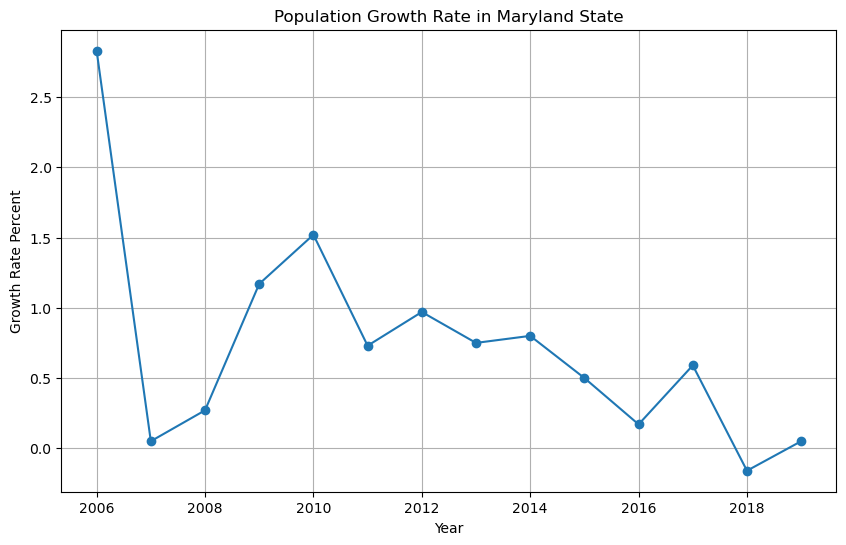

In [15]:
import matplotlib.pyplot as plt

year = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
growth_rate_percent = [2.83, 0.05, 0.27, 1.17, 1.52, 0.73, 0.97, 0.75, 0.80, 0.50, 0.17, 0.59, -0.16, 0.05]

plt.figure(figsize=(10,6))
plt.plot(year, growth_rate_percent, marker='o')
plt.title('Population Growth Rate in Maryland State')
plt.xlabel('Year')
plt.ylabel('Growth Rate Percent')
plt.grid(True)
plt.show()

### Markdown Explanation: 
- In this chart, it is visible that there is a steep drop in the population growth rate from 2006 to 2007 of approximately 2.75%. There is a slight increase from 2007 to 2010 and another drop from 2010 to 2011. There is then a steady drop from 2011 to 2019. 

## Q2 – Income and Population Relationship

In [16]:
q2_sql = """

SELECT
	p.year,
	s.name AS state_income, 
	p.pop AS yearly_income, 
	i.income AS yearly_income
FROM
	population AS p
INNER JOIN
	income as i
	ON p.fips = i.fips AND p.year = i.year
INNER JOIN
	name AS s
	ON p.fips = s.fips
WHERE
	s.name = 'Maryland'
ORDER BY
	p.year ASC """

In [17]:
q2_df = pd.read_sql(q2_sql, con=conn)
q2_df.head() #show the top 5 rows

,year,state_income,yearly_income,yearly_income
0,2005,Maryland,5461318,61592
1,2006,Maryland,5615727,65144
2,2007,Maryland,5618344,68080
3,2008,Maryland,5633597,70545
4,2009,Maryland,5699478,69272


In [18]:
%%ai gpt4
What is included in the {q2_df}

The given data includes:

1. `Year`: This column shows the year for which the income data is given.

2. `State Income`: This column indicates the state for which the income data is given, which in this case is Maryland.

3. `Yearly Income`: This column shows the total state income for Maryland for that particular year.

4. `Yearly Income`: It seems there's a duplication of the `Yearly Income` column. Its purpose isn't clear as there's no difference in the headings to differentiate them. Assuming it's a different type of income data or a data entry mistake until further information is provided. This needs clarification to interpret correctly.

The data illustrates the yearly income (total or another type) of Maryland state for the years between 2005 to 2019. It helps to track the increase or decrease of the income over these years. According to this data, the income number has been growing steadily over the given years.

In [19]:
%%ai gpt4 -f code
use the data in {q2_df}, create a dual-axis chart with the x-axis being year, the left y-axis being population (line), and the right x-axis being median household income (bar or line, different color). Make sure to include Maryland in the title.

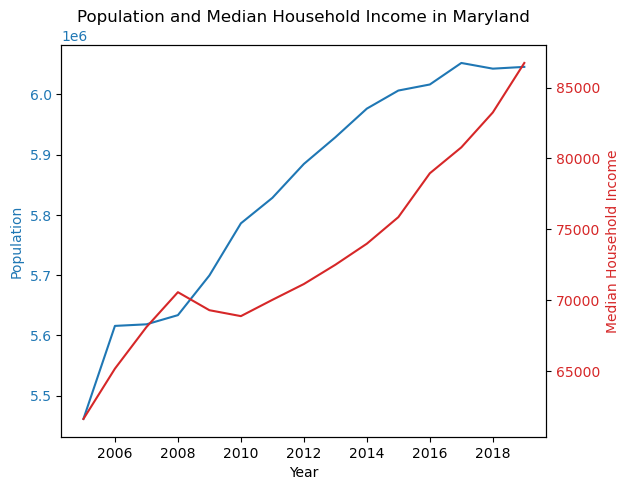

In [20]:
import matplotlib.pyplot as plt

year = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
state_income = [5461318, 5615727, 5618344, 5633597, 5699478, 5785982, 5828289, 5884563, 5928814, 5976407, 6006401, 6016447, 6052177, 6042718, 6045680]
yearly_income = [61592, 65144, 68080, 70545, 69272, 68854, 70004, 71122, 72483, 73971, 75847, 78945, 80776, 83242, 86738]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.plot(year, state_income, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Median Household Income', color=color)
ax2.plot(year, yearly_income, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Population and Median Household Income in Maryland')
plt.show()

### Markdown Explanation:
- Based on this chart, it is apparent that in Maryland, there is consistent population growth year-by-year. It is also apparent that income levels are steadily increasing from around $65,000 (2006) to $85,000 (2018). Overall, this shows that while population growth is slightly slowing, income growth is still strong, suggesting that there might be more productivity or increased wages, leading to a stable and growing economy in Maryland. 

## Q3 – What is the annual growth rate of the population for the past years? (Student-Defined Question)

In [21]:
q3_sql = """

SELECT
    curr.year AS current_year,
    curr.pop AS current_population,
    prev.pop AS previous_population,
    ROUND(
        (CAST(curr.pop AS NUMERIC) - prev.pop) / prev.pop * 100,
        2
    ) AS growth_rate_percent
FROM population curr
JOIN population prev ON curr.fips = prev.fips AND curr.year = prev.year + 1
JOIN name ON name.fips = curr.fips
WHERE name.name = 'Maryland'
ORDER BY curr.year; """

In [22]:
q3_df = pd.read_sql(q3_sql, con=conn)
q3_df.head() #show the top 5 rows

,current_year,current_population,previous_population,growth_rate_percent
0,2006,5615727,5461318,2.83
1,2007,5618344,5615727,0.05
2,2008,5633597,5618344,0.27
3,2009,5699478,5633597,1.17
4,2010,5785982,5699478,1.52


In [23]:
%%ai gpt4
What is included in the {q3_df}

The given data includes:

1. `current_year`: This column shows the year for which the population data is presented.

2. `current_population`: This column indicates the population for the current year mentioned.

3. `previous_population`: This column displays the population of the previous year for comparison purposes.

4. `growth_rate_percent`: This column shows the growth rate percent of the population from the previous year to the current year. This data can be positive (indicating growth), negative (indicating decline), or zero (indicating no change).

The data provides a yearly overview of the population growth rate in a particular location (unmentioned in the provided data) for the years extending from 2006 to 2019. This type of data is useful for understanding demographic trends over time.

In [24]:
%%ai gpt4 -f code
Make an appropriate chart for {q3_df} and make sure to put the state name (Maryland) in the title.

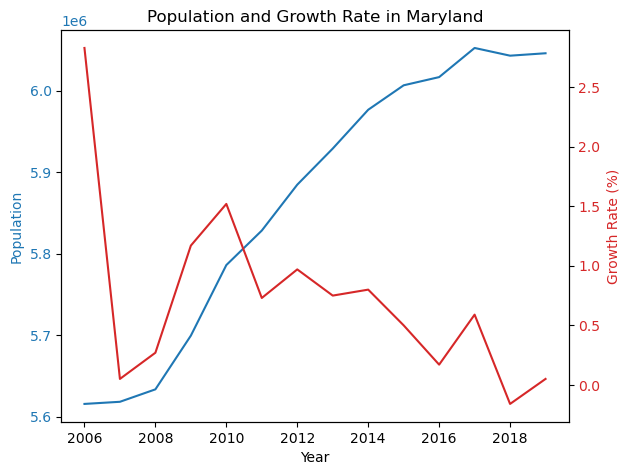

In [26]:
import matplotlib.pyplot as plt

current_year = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
current_population = [5615727, 5618344, 5633597, 5699478, 5785982, 5828289, 5884563, 5928814, 5976407, 6006401, 6016447, 6052177, 6042718, 6045680]
growth_rate_percent = [2.83, 0.05, 0.27, 1.17, 1.52, 0.73, 0.97, 0.75, 0.80, 0.50, 0.17, 0.59, -0.16, 0.05]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.plot(current_year, current_population, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Growth Rate (%)', color=color)
ax2.plot(current_year, growth_rate_percent, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Population and Growth Rate in Maryland')
plt.show()

### Markdown Explanation:
- Based on this chart, it is apparent that the population growth rate had a steep decrease in 2007 dropping to approximately 0.2%. It is also apparent that the population growth rate in Maryland has frequent fluctuations, indicating potential external factors (economic fluctuations, migration). The other line, showing the overall population of Maryland, has been increasing steadily from 2006 to 2018. There have been slight drops, but an overall increase from around 5.6 million to 6.05 million. 